# Brownian bridges

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
from tueplots import bundles

# plt.rcParams.update(bundles.icml2024())
from flax import nnx

from neuralbridge.sdes.examples import BrownianSDE, BrownianBridgeSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedProposalSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import load

Unconditioned Brownian process:
$$
\mathrm d X_t = \gamma \mathrm d t + \sigma \mathrm d W_t
$$
Auxiliary process (scaled Brownian motion):
$$
\mathrm d \tilde X_t = \sigma \mathrm d W_t
$$

In [3]:
def construct_neural_bridge(gamma, sigma, x0, vT, T, rngs):
    sde = BrownianSDE(
        dim_x=1,
        dim_w=1,
        params={
            "gamma": jnp.array([gamma]),
            "sigma": jnp.array([[sigma]])
        }
    )

    # A standard Brownian motion as the auxiliary SDE
    aux_sde = AuxiliarySDE(
        dim_x=1,
        dim_w=1,
        coeffs={
            "T": 1.0,
            "beta": lambda t: jnp.array([0.0]),
            "B": lambda t: jnp.array([[0.0]]),
            "a_tilde_0": None,
            "a_tilde_T": jnp.array([[sigma**2]])
        }
    )

    n_steps = 1000           # number of time steps
    ts = jnp.linspace(0., 1., n_steps+1, endpoint=True)
    epsilon = 1e-5          # observation noise

    guided_sde = GuidedProposalSDE(
        sde, aux_sde,
        obs_params={
            "vT": vT,
            "LT": jnp.eye(1),   # fully observed
            "SigmaT": epsilon**2 * jnp.eye(1)
        },
        ts=ts,
        eq_type="uLM",          # u, L, M formulation of BIF ODE
    )

    b_fn = guided_sde.b
    sigma_fn = guided_sde.sigma
    G_fn = guided_sde.G

    nn_config = {
        "model_name": "MLPSmall",
        "input_dim": 1,
        "output_dim": 1,
        "hidden_dims": (20, 20, 20),
        "act_type": "tanh",
        "rngs": rngs
    }
           
    neural_bridge = NeuralBridge(
        b_fn, sigma_fn, G_fn, nn_config
    )
    
    return neural_bridge, guided_sde

The scaled Brownian motion with constant drift holds the transition density:
$$
p_{s, t}(x, y) = \frac{1}{\sqrt{2\pi\sigma^2(t-s)}}\exp\left(-\frac{(y-x-\gamma(t-s))^2}{2\sigma^2(t-s)}\right).
$$
Therefore, without observation noise, the $h(t, x)$ holds the closed-form:
$$
h(t, x) = p_{t, T}(x, v) = \frac{1}{\sqrt{2\pi\sigma^2(T-t)}}\exp\left(-\frac{(v-x-\gamma(T-s))^2}{2\sigma^2(T-s)}\right),
$$
and
$$
\log h(t, x) = -\frac{1}{2}\log(2\pi\sigma^2(T-t)) - \frac{(v-x-\gamma(T-t))^2}{2\sigma^2(T-t)}, \\
\nabla_x \log h(t, x) = \frac{v - x - \gamma (T-t)}{\sigma^2(T-t)}.
$$
The auxiliary process is a scaled Brownian motion, therefore
$$
\log\tilde h(t, x) = -\frac{1}{2}\log(2\pi\sigma^2(T-t)) - \frac{(v - x)^2}{2\sigma^2(T-t)}, \\
\nabla_x \log \tilde h(t, x) = \frac{v - x}{\sigma^2(T-t)}.
$$
Therefore, the optimal lower bound of $L$ should be:
$$
L(\theta_{\text{opt}}) = \log\tilde h(0, x_0) - \log h(0, x_0) =  \frac{(v-x-\gamma T)^2 - (v-x)^2}{2\sigma^2T}
$$
Similarly, the optimal value of $\vartheta$ can be derived:
$$
\vartheta_{\theta_{\text{opt}}} = \sigma^{\top}(\nabla_x\log h(t, x) - \nabla_x\log\tilde h(t, x)) = -\frac{\gamma}{\sigma}
$$ 

In [30]:
def log_tilde_h(t, x, sigma, vT, T):
    return -0.5 * jnp.log(2 * jnp.pi * sigma**2 * (T - t)) - (vT - x)**2 / (2 * sigma**2 * (T - t))

def log_h(t, x, gamma, sigma, vT, T):
    return -0.5 * jnp.log(2 * jnp.pi * sigma**2 * (T - t)) - (vT - x - gamma * (T - t))**2 / (2 * sigma**2 * (T - t))

def L_opt(gamma, sigma, x0, vT, T):
    return log_tilde_h(0, x0, sigma, vT, T) - log_h(0, x0, gamma, sigma, vT, T)

def nn_opt(gamma, sigma, t, x, vT, T):
    return - gamma / sigma

print(f"Under the settings of gamma={1.0}, sigma={1.0}, x0={0.0}, vT={0.0}, T={1.0}, the optimal value of L is {L_opt(1.0, 1.0, 0.0, 0.0, 1.0)}")
print(f"Under the settings of gamma={1.0}, sigma={0.5}, x0={0.0}, vT={0.0}, T={1.0}, the optimal value of L is {L_opt(1.0, 0.5, 0.0, 0.0, 1.0)}")
print(f"Under the settings of gamma={2.0}, sigma={1.0}, x0={0.0}, vT={0.0}, T={1.0}, the optimal value of L is {L_opt(2.0, 1.0, 0.0, 0.0, 1.0)}")
print(f"Under the settings of gamma={-2.0}, sigma={1.0}, x0={0.0}, vT={0.0}, T={1.0}, the optimal value of L is {L_opt(-2.0, 1.0, 0.0, 0.0, 1.0)}")

Under the settings of gamma=1.0, sigma=1.0, x0=0.0, vT=0.0, T=1.0, the optimal value of L is 0.5
Under the settings of gamma=1.0, sigma=0.5, x0=0.0, vT=0.0, T=1.0, the optimal value of L is 2.0
Under the settings of gamma=2.0, sigma=1.0, x0=0.0, vT=0.0, T=1.0, the optimal value of L is 2.0
Under the settings of gamma=-2.0, sigma=1.0, x0=0.0, vT=0.0, T=1.0, the optimal value of L is 2.0


In [31]:
losses_1 = jnp.load(f"../assets/ckpts/neural_bridge/brownian/gamma_1.0_sigma_1.0/losses.npy")
losses_2 = jnp.load(f"../assets/ckpts/neural_bridge/brownian/gamma_1.0_sigma_0.5/losses.npy")
losses_3 = jnp.load(f"../assets/ckpts/neural_bridge/brownian/gamma_2.0_sigma_1.0/losses.npy")
losses_4 = jnp.load(f"../assets/ckpts/neural_bridge/brownian/gamma_-2.0_sigma_1.0/losses.npy")

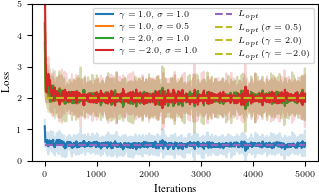

In [34]:
def smooth_losses(losses, window_size=50):
    if window_size >= len(losses):
        return losses
    
    kernel = jnp.ones(window_size) / window_size
    padded_losses = jnp.pad(losses, (window_size//2, window_size//2), mode='edge')
    smoothed = jnp.convolve(padded_losses, kernel, mode='valid')
    
    return smoothed

window_size = 11
smooth_losses_1 = smooth_losses(losses_1, window_size)
smooth_losses_2 = smooth_losses(losses_2, window_size)
smooth_losses_3 = smooth_losses(losses_3, window_size)
smooth_losses_4 = smooth_losses(losses_4, window_size)

fig, ax = plt.subplots()
ax.plot(losses_1, alpha=0.2, color='C0')
ax.plot(smooth_losses_1, label=r'$\gamma = 1.0, \sigma=1.0$', color='C0')
ax.plot(losses_2, alpha=0.2, color='C1')
ax.plot(smooth_losses_2, label=r'$\gamma = 1.0, \sigma=0.5$', color='C1')
ax.plot(losses_3, alpha=0.2, color='C2')
ax.plot(smooth_losses_3, label=r'$\gamma = 2.0, \sigma=1.0$', color='C2')
ax.plot(losses_4, alpha=0.2, color='C3')
ax.plot(smooth_losses_4, label=r'$\gamma = -2.0, \sigma=1.0$', color='C3')
ax.hlines(y=0.5, xmin=0, xmax=len(losses_1), linestyle='--', color='C4', label=r'$L_{opt}$')
ax.hlines(y=2.0, xmin=0, xmax=len(losses_2), linestyle='--', color='C8', label=r'$L_{opt}\,(\sigma=0.5)$')
ax.hlines(y=2.0, xmin=0, xmax=len(losses_3), linestyle='--', color='C8', label=r'$L_{opt}\,(\gamma=2.0)$')
ax.hlines(y=8.0, xmin=0, xmax=len(losses_4), linestyle='--', color='C8', label=r'$L_{opt}\, (\gamma=-2.0)$') 
ax.set_ylim(0., 5.0)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.legend(ncol=2)
fig.savefig('../assets/figures/brownian/losses.pdf')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Loaded latest model from step 5000
Loaded latest model from step 5000
Loaded latest model from step 5000
Loaded latest model from step 5000


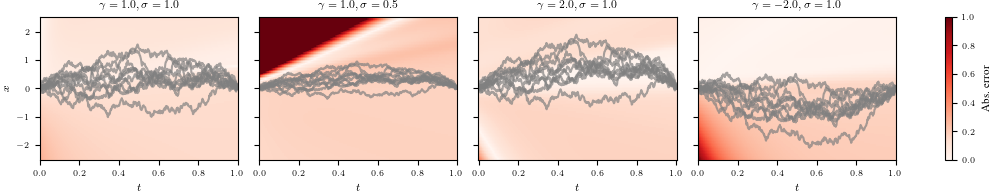

In [38]:
rngs = nnx.Rngs(42)
x0 = jnp.array([0.0])
vT = jnp.array([0.0])
T = 1.0
n_steps = 500
ts = jnp.linspace(0., 1., n_steps+1)

xs = jnp.linspace(-2.5, 2.5, 100)
tt, xx = jnp.meshgrid(ts, xs)
grid_points = jnp.stack([tt.flatten(), xx.flatten()], axis=1) 

def vectorized_eval(func, grid_points):
    t_vals = grid_points[:, 0]
    x_vals = grid_points[:, 1].reshape(-1, 1)
    outputs = jax.vmap(lambda t, x: func(t, x))(t_vals, x_vals)
    return outputs.reshape(ts.shape[0], xs.shape[0])

fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharex=True, sharey=True)

norm = plt.Normalize(vmin=0.0, vmax=1.0)

# gamma = 1.0, sigma = 1.0
gamma = 1.0
sigma = 1.0
neural_bridge, guided_sde = construct_neural_bridge(gamma, sigma, x0, vT, 1.0, rngs)
load(neural_bridge, ckpt_dir=f"../assets/ckpts/neural_bridge/brownian/gamma_{gamma}_sigma_{sigma}")
guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)
    
neural_bridge.eval()
    
true_score = lambda t, x: nn_opt(gamma, sigma, t, x, vT, T)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)

nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)

abs_error = jnp.abs(nn_outputs - true_outputs)
        
im = axes[0].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)
    
for i in range(guided_traj.shape[0]):
    axes[0].plot(ts, guided_traj[i], color='grey', alpha=0.7)
        
axes[0].set_xlabel(r'$t$')
axes[0].set_title(fr'$\gamma = {gamma:.1f}, \sigma = {sigma:.1f}$')
axes[0].set_ylabel(r'$x$')

# gamma = 1.0, sigma = 0.5
gamma = 1.0
sigma = 0.5
neural_bridge, guided_sde = construct_neural_bridge(gamma, sigma, x0, vT, 1.0, rngs)
load(neural_bridge, ckpt_dir=f"../assets/ckpts/neural_bridge/brownian/gamma_{gamma}_sigma_{sigma}")
guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

neural_bridge.eval()
    
true_score = lambda t, x: nn_opt(gamma, sigma, t, x, vT, T)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)

nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)

abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[1].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)

for i in range(guided_traj.shape[0]):
    axes[1].plot(ts, guided_traj[i], color='grey', alpha=0.7)

axes[1].set_xlabel(r'$t$')
axes[1].set_title(fr'$\gamma = {gamma:.1f}, \sigma = {sigma:.1f}$')

# gamma = 2.0, sigma = 1.0
gamma = 2.0
sigma = 1.0
neural_bridge, guided_sde = construct_neural_bridge(gamma, sigma, x0, vT, 1.0, rngs)
load(neural_bridge, ckpt_dir=f"../assets/ckpts/neural_bridge/brownian/gamma_{gamma}_sigma_{sigma}")
guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

neural_bridge.eval()
    
true_score = lambda t, x: nn_opt(gamma, sigma, t, x, vT, T)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)

nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)

abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[2].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)

for i in range(guided_traj.shape[0]):
    axes[2].plot(ts, guided_traj[i], color='grey', alpha=0.7)

axes[2].set_xlabel(r'$t$')
axes[2].set_title(fr'$\gamma = {gamma:.1f}, \sigma = {sigma:.1f}$')

# gamma = -2.0, sigma = 1.0
gamma = -2.0
sigma = 1.0
neural_bridge, guided_sde = construct_neural_bridge(gamma, sigma, x0, vT, 1.0, rngs)
load(neural_bridge, ckpt_dir=f"../assets/ckpts/neural_bridge/brownian/gamma_{gamma}_sigma_{sigma}")
guide_solve = SDESolver(guided_sde, method='milstein')
guided_traj = guide_solve.batch_solve(jr.PRNGKey(42), x0, ts, 10)

neural_bridge.eval()
    
true_score = lambda t, x: nn_opt(gamma, sigma, t, x, vT, T)

nn_outputs = vectorized_eval(neural_bridge.nn, grid_points)
true_outputs = vectorized_eval(true_score, grid_points)

nn_outputs = nn_outputs.reshape(xs.shape[0], ts.shape[0], 1)
true_outputs = true_outputs.reshape(xs.shape[0], ts.shape[0], 1)

abs_error = jnp.abs(nn_outputs - true_outputs)

im = axes[3].pcolormesh(ts, xs, abs_error[:, :, 0], cmap='Reds', norm=norm)

for i in range(guided_traj.shape[0]):
    axes[3].plot(ts, guided_traj[i], color='grey', alpha=0.7)

axes[3].set_xlabel(r'$t$')
axes[3].set_title(fr'$\gamma = {gamma:.1f}, \sigma = {sigma:.1f}$')

cbar = fig.colorbar(im, ax=axes.tolist())
cbar.set_label('Abs. error')

fig.savefig('../assets/figures/brownian/errors.pdf')
plt.show()

In [45]:
bridge_sde = BrownianBridgeSDE(
    dim=1,
    params={
        "gamma": jnp.array([1.0]),
        "sigma": jnp.array([[1.0]]),
    },
    vT=vT,
    T=1.0
)

In [47]:
neural_bridge, _ = construct_neural_bridge(1.0, 1.0, x0, vT, 1.0, rngs)
load(neural_bridge, ckpt_dir=f"../assets/ckpts/neural_bridge/brownian/gamma_1.0_sigma_1.0", load_best=True)

nb_solver = SDESolver(neural_bridge, method="milstein")
tb_solver = SDESolver(bridge_sde, method="milstein")

n_samples = 50_000
rng_key = jr.PRNGKey(42)

nb_traj = nb_solver.batch_solve(rng_key, x0, ts, n_samples)
tb_traj = tb_solver.batch_solve(rng_key, x0, ts, n_samples)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Loaded best model from step 4700


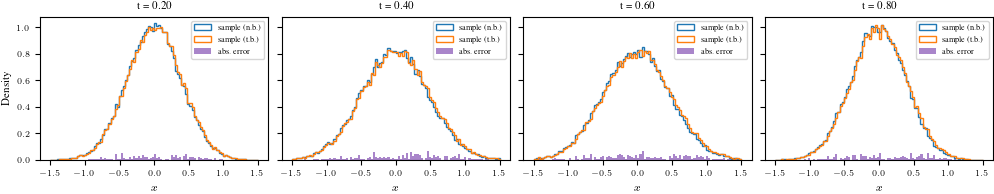

In [49]:
t_slices = [0.2, 0.4, 0.6, 0.8]
x_range = (-1.5, 1.5)

fig, axes = plt.subplots(1, 4, figsize=(10, 2), sharey=True, sharex=True)

for i, t_slice in enumerate(t_slices):
    t_idx = jnp.where(ts == t_slice)[0][0]
    
    ax = axes[i]
    ax.hist(nb_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C0')
    ax.hist(tb_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (t.b.)', histtype='step', edgecolor='C1')
    
    nb_hist, _       = np.histogram(nb_traj[:, t_idx, 0], bins=100, density=True, range=x_range)
    tb_hist, bin_edges = np.histogram(tb_traj[:, t_idx, 0], bins=100, density=True, range=x_range)
    er_hist = np.abs(nb_hist - tb_hist)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.bar(bin_centers, er_hist, width=np.diff(bin_edges), color='C4', label='abs. error', alpha=0.8, bottom=0.0, fill=True)
    
    ax.set_xlabel(r'$x$')
    ax.set_title(f't = {t_slice:.2f}')
    ax.legend(loc='upper right')

axes[0].set_ylabel('Density')
fig.savefig('../assets/figures/brownian/histograms.pdf')
plt.show()